In [36]:
import numpy as np
import random
import pandas as pd
import numpy as np
import seaborn as sns
import mpu
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import train_test_split

### Success targets

In [2]:
city        = 'london'
datafile    = 'FINAL_DATA'
successdata = datafile + '/london_venues_success_measures.csv'
success     = pd.read_csv(successdata, sep = '\t', index_col = 0)
success     = success[~success.index.duplicated(keep='first')]   

successdata_L = datafile + '/london_venues_success_measures_local_like.csv'
success_L     = pd.read_csv(successdata_L, sep = '\t', index_col = 0)
success_L     = success_L[~success_L.index.duplicated(keep='first')]   
success       = success.join(success_L)

success.index.name = 'venue'
success.head()

,tipCount,checkinsCount,usersCount,Llikecount
venue,,,,
4a5f9446f964a520e0bf1fe3,75.0,2500.0,1831.0,33.195062
4abcec53f964a520b98720e3,17.0,1550.0,913.0,16.468388
4abdc1c7f964a5206d8b20e3,47.0,5573.0,2777.0,91.575568
4abe4502f964a520558c20e3,575.0,97190.0,80793.0,445.616354
4abe5714f964a520d68c20e3,54.0,1507.0,1256.0,49.789535


In [3]:
def get_success_Qs(segments, success, measure, randomized = False):

    if randomized: 
        np.random.shuffle(success[measure])
        
    labels = ['q' + str(i+1) for i in range(segments)]    
        
    success['quartile'] = pd.qcut(success[measure], segments, labels)
    Q1 = list(success[success['quartile'] == labels[0]].index)
    Q4 = list(success[success['quartile'] == labels[-1]].index)

    
    return Q1, Q4, success


VenuesTop, VenuesBottom, success = get_success_Qs(4, success, 'checkinsCount', randomized = False)

### Get the features 

In [5]:
features_f = 'FINAL_DATA/FINAL_FEATURES.csv'
features   = pd.read_csv(features_f, sep = '\t', index_col = 0)

features.head()

,WHERE_sub_region,WHERE_distance_from_center,WHERE_building,WHERE_food,WHERE_na,WHERE_travel,WHERE_Venues_num,WHERE_user_centroids,WHERE_parks_outdoors,WHERE_Entropy,...,WHO_v_wa_pagerank_inv_distances,WHO_v_wa_geo_stdev_of_ego_inv_distances,WHO_v_wa_betweenness_wa,WHO_v_wa_clustering_grav_distances,WHO_v_wa_geo_social_stretch_distances,WHO_v_wa_egosize,WHO_v_wa_geo_stdev_of_ego_distances,WHO_v_wa_constraint_wa,WHO_v_wa_pagerank_exp_distances,WHO_v_wa_eigenvector
venue,,,,,,,,,,,,,,,,,,,,,
4a5f9446f964a520e0bf1fe3,0,4.064099,0.175676,0.280405,0.010135,0.187500,592,192,0.043919,0.811208,...,0.000021,0.0,0.0,0.0,2.019477,2.0,0.0,1.0,0.000019,0.0
4abcec53f964a520b98720e3,0,0.232250,0.202420,0.303504,0.009327,0.072473,7934,4835,0.043988,0.827807,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
4abdc1c7f964a5206d8b20e3,0,2.306181,0.317386,0.252042,0.016336,0.039090,1714,651,0.030922,0.781289,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
4abe4502f964a520558c20e3,0,1.137742,0.202420,0.303504,0.009327,0.072473,7934,4835,0.043988,0.827807,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
4abe5714f964a520d68c20e3,0,0.707539,0.199941,0.273588,0.016169,0.053239,10143,5276,0.012620,0.770677,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0


In [6]:
features_VenuesTop    = features[features.index.isin(VenuesTop)]
features_VenuesBottom = features[features.index.isin(VenuesBottom)]

features_VenuesTop.head()
features_VenuesBottom.head()

,WHERE_sub_region,WHERE_distance_from_center,WHERE_building,WHERE_food,WHERE_na,WHERE_travel,WHERE_Venues_num,WHERE_user_centroids,WHERE_parks_outdoors,WHERE_Entropy,...,WHO_v_wa_pagerank_inv_distances,WHO_v_wa_geo_stdev_of_ego_inv_distances,WHO_v_wa_betweenness_wa,WHO_v_wa_clustering_grav_distances,WHO_v_wa_geo_social_stretch_distances,WHO_v_wa_egosize,WHO_v_wa_geo_stdev_of_ego_distances,WHO_v_wa_constraint_wa,WHO_v_wa_pagerank_exp_distances,WHO_v_wa_eigenvector
venue,,,,,,,,,,,,,,,,,,,,,
4a5f9446f964a520e0bf1fe3,0,4.064099,0.175676,0.280405,0.010135,0.187500,592,192,0.043919,0.811208,...,0.000021,0.0,0.0,0.0,2.019477,2.0,0.0,1.0,0.000019,0.0
4abcec53f964a520b98720e3,0,0.232250,0.202420,0.303504,0.009327,0.072473,7934,4835,0.043988,0.827807,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
4abdc1c7f964a5206d8b20e3,0,2.306181,0.317386,0.252042,0.016336,0.039090,1714,651,0.030922,0.781289,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
4abe4502f964a520558c20e3,0,1.137742,0.202420,0.303504,0.009327,0.072473,7934,4835,0.043988,0.827807,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
4abe5714f964a520d68c20e3,0,0.707539,0.199941,0.273588,0.016169,0.053239,10143,5276,0.012620,0.770677,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0


### Classification

In [40]:
# get the data
# Q1 = top
# Q4 = bottom

features_VenuesTop['success']    = 1
features_VenuesBottom['success'] = 0

X = features_VenuesTop.append(features_VenuesBottom)
y = np.asarray(X.success)
X = X.drop(columns = ['success'])


/home/milan/.local/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/milan/.local/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [10]:
def classifiers(X, y):
   


    classifier = RandomForestClassifier(max_depth=5, n_estimators=10, max_features='auto') 
    # preprocess dataset, split into training and test part
    # X = StandardScaler().fit_transform(X)
    # X = preprocessing.quantile_transform(X, output_distribution = 'normal')
    X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=.33, random_state=42)

    # iterate over classifiers
    classifier.fit(X_train, y_train)
    score = classifier.score(X_test, y_test)
    print  'CrossCalScore\t', score, np.mean(cross_val_score(classifier, X_train, y_train, cv=3))

        
classifiers(X, y)

CrossCalScore	0.9115917057809994 0.9076705218498007


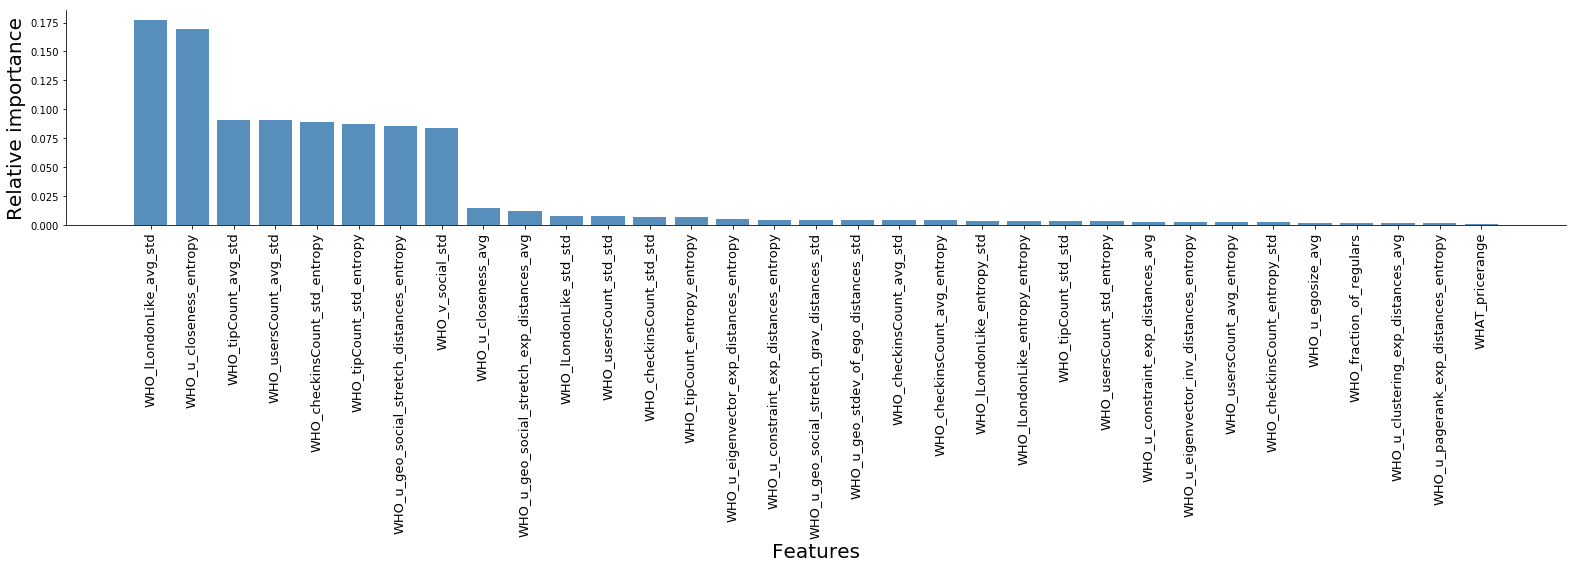

In [15]:
def importance(X, y):
   

    classifier = RandomForestClassifier(max_depth=5, n_estimators=10, max_features='auto') 

    classifier.fit(X, y)
    
    X_head = X.keys()
    
    importances = classifier.feature_importances_
    std         = np.std([tree.feature_importances_ for tree in classifier.estimators_], axis=0)
    indices     = np.argsort(importances)[::-1]
    

    df = pd.DataFrame()
    df['ind'], df['val'], xlabels = zip(*[(X_head[i], importances[i], X_head[i]) for i in indices])

    
    df    = df.sort_values(['val'], ascending = False)
    f, ax = plt.subplots(1, 1, figsize=(22, 8))
    
    impy = [i for i in importances[indices] if i > 0.001]
    

    ax.bar(range(len(impy)), impy, color="steelblue", alpha = 0.9, align="center")

    #ax.bar(range(X.shape[1]), importances[indices], color="steelblue", alpha = 0.9, align="center")
    #ax.bar(range(X.shape[1]), importances[indices], color="steelblue", alpha = 0.9,yerr=std[indices], align="center")

    #ax.set_xticks(sorted(indices))
    ax.set_xticks(range(len(impy)))
    ax.set_xticklabels(xlabels, rotation = 90, fontsize = 13)

    ax.set_ylabel('Relative importance', fontsize = 20)
    ax.set_xlabel('Features', fontsize = 20)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()
 
    return importances[indices]

importances = importance(X, y)

In [56]:
[i for i in importances if i > 0.001]

[0.18732060864014294,
 0.09845253114912303,
 0.09486249819398886,
 0.0947901874696338,
 0.09253883080979886,
 0.09154641429605856,
 0.09131830818836506,
 0.08894420848977394,
 0.05558756215136716,
 0.04206804174226713,
 0.0057375521958624495,
 0.0055890242895001215,
 0.004890576834393822,
 0.004885949837577103,
 0.004326706708031225,
 0.004246044580273364,
 0.003964798714757526,
 0.0038713058060620316,
 0.0029525685620996147,
 0.0025527492169331854,
 0.00251423153576284,
 0.0015355822104604587,
 0.001369936875252171,
 0.0013251545970052049]

In [ ]:
random reshuffle labels!

In [41]:
def classifiers_types(X, y, tipus = '', randomize = False):
   

    if randomize: 
        random.shuffle(y)
        
    X_ = X.drop(columns = [  c for c in X.keys() if tipus not in c  ])    
    

    classifier = RandomForestClassifier(max_depth=5, n_estimators=10, max_features='auto') 
    # preprocess dataset, split into training and test part
    # X = StandardScaler().fit_transform(X)
    # X = preprocessing.quantile_transform(X, output_distribution = 'normal')
    X_train, X_test, y_train, y_test =  train_test_split(X_, y, test_size=.33, random_state=42)

    # iterate over classifiers
    classifier.fit(X_train, y_train)
    score = classifier.score(X_test, y_test)
    meanc = np.mean(cross_val_score(classifier, X_train, y_train, cv=3))
    print  'CrossCalScore\t', score, meanc

    return meanc
        
allf   = classifiers_types(X, y, tipus = '', randomize = False)
where  = classifiers_types(X, y, tipus = 'WHERE', randomize = False)
who    = classifiers_types(X, y, tipus = 'WHO',   randomize = False)
what   = classifiers_types(X, y, tipus = 'WHAT',  randomize = False)
rand   = classifiers_types(X, y, tipus = '', randomize = True)

CrossCalScore	0.9108193214901076 0.9088117685765135
CrossCalScore	0.6303249955439367 0.6157267678217401
CrossCalScore	0.9117699483096667 0.9074655687178854
CrossCalScore	0.6087576495751886 0.607796150229045
CrossCalScore	0.49919790862099694 0.5022384629728376


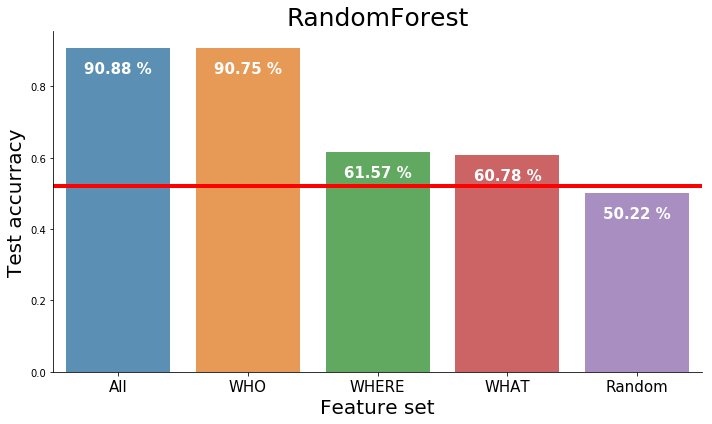

In [47]:
%matplotlib inline
df = pd.DataFrame()
df['ind'] = ['All','WHO', 'WHERE', 'WHAT', 'Random']
df['val'] = [allf, who, where, what, rand]
df        = df.sort_values(['val'], ascending = False)


f, ax = plt.subplots(1, 1, figsize=(10, 6))

sns.barplot(x="ind", y="val", data=df, ax = ax, alpha = 0.8, capsize=.2 )
ax.set_ylabel('Test accurracy', fontsize = 20)
ax.set_xlabel('Feature set', fontsize = 20)
ax.set_xticklabels(df['ind'], fontsize = 15)
#ax.set_yticklabels(['0%', '10%','20%','30%','40%', '50%', '60%'], fontsize = 15)

ax.axhline(y = 0.52, linewidth=4, color='r')
ax.set_title('RandomForest', fontsize = 25)
rects = ax.patches

for rect, label in zip(rects, df['val']):
    height = rect.get_height()
    label = str(round(100*label, 2)) + ' %'
    ax.text(rect.get_x() + rect.get_width() / 2, height-0.08 , label,ha='center', weight = 'bold', va='bottom', color = 'white', fontsize = 15)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()